# Testing a 2D KL divergence

From [atabakd on GitHub](https://gist.github.com/atabakd/ed0f7581f8510c8587bc2f41a094b518)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree as KDTree

In [3]:
# https://mail.python.org/pipermail/scipy-user/2011-May/029521.html

def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """

  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))

## Test with mock data

In [33]:
rng = np.random.default_rng()
datax = rng.normal(loc=0, scale=1, size=100000)
datay = rng.normal(loc=0, scale=1, size=100000)
modelx = rng.normal(loc=0, scale=1.5, size=90000)
modely = rng.normal(loc=0, scale=0.2, size=90000)
Psamples = np.array([datax, datay]).T
Qsamples = np.array([modelx, modely]).T

In [34]:
KLdivergence(Psamples, Qsamples)

3.969411792860216

## Test with APOGEE and VICE

In [39]:
import sys
import os
sys.path.append(os.path.abspath('../src/scripts'))
from utils import multioutput_to_pandas, filter_multioutput_stars, apogee_region, sample_dataframe

In [36]:
apogee_data = pd.read_csv('../src/data/APOGEE/sample.csv')
vice_stars  = multioutput_to_pandas('diffusion/insideout/powerlaw_slope11', data_dir='../src/data/migration')

In [69]:
galr_lim = (7, 9)
absz_lim = (0, 0.5)
apogee_subset = apogee_region(apogee_data, galr_lim, absz_lim)
apogee_subset.dropna(subset=['FE_H', 'O_FE'], inplace=True)
vice_subset = filter_multioutput_stars(vice_stars, galr_lim, absz_lim)

In [70]:
apogee_sample = sample_dataframe(apogee_subset, 5000)
sample_weights = vice_subset['mass'] / vice_subset['mass'].sum()
vice_sample = sample_dataframe(vice_subset, 5000, weights=sample_weights)

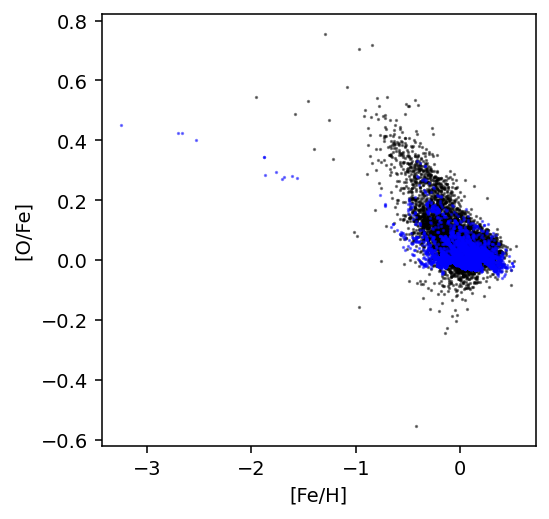

In [71]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=140)
ax.scatter(apogee_sample['FE_H'], apogee_sample['O_FE'], c='k', alpha=0.5, s=0.5)
ax.scatter(vice_sample['[fe/h]'], vice_sample['[o/fe]'], c='b', alpha=0.5, s=0.5)
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('[O/Fe]')
plt.show()

In [72]:
Psamples = apogee_subset[['FE_H', 'O_FE']]
Qsamples = vice_subset[['[fe/h]', '[o/fe]']]

KLdivergence(Psamples, Qsamples)

3.0760712815963585

In [74]:
sample1 = sample_dataframe(apogee_subset, 5000)
sample2 = sample_dataframe(apogee_subset, 6000)
KLdivergence(sample1[['FE_H', 'O_FE']], sample2[['FE_H', 'O_FE']])

/tmp/ipykernel_185/1485136584.py:46: RuntimeWarning: divide by zero encountered in true_divide
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


-inf